In [32]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
import numpy as np
import datetime as dt
from rasterstats import zonal_stats

In [33]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

In [34]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Landuse_Analysis')


In [35]:
def crop_counts(boundaries, year):
    tiff = '01-01-'+str(year)+'.tif'
    lulc = rasterio.open(tiff, mode = 'r')
    lulc_array = lulc.read(1) # landuse corresponding to each rasterpixel, so we extracted the pixel values from the raster
    # affine: 1: corresponds to the width of each pixel, 2: row rotation, 3: x-coordinate of the upper left pixel, 4: column rotation, 5: height of each pixel, 6: y-coordinate of the upper left pixel
    affine = lulc.transform

    cmap = {1: 'Water', 2: 'Trees', 4: 'Flooded Vegetation', 5: 'Crops', 7: 'Built Area', 8: 'Bare Ground', 9: 'Snow/Ice', 10: 'Clouds', 11: 'Rangeland'}
    boundaries['Crops ' + str(year)] = 0

    for i in range(0, len(boundaries)):
        test = zonal_stats(boundaries.iloc[i].geometry, lulc_array, affine = affine, geojson_out = True, nodata = lulc.nodata, categorical=True, category_map = cmap)
        try:
            boundaries['Crops ' + str(year)].iloc[i] = test[0]['properties']['Crops']  
        except:
            boundaries['Crops ' + str(year)].iloc[i] = 0
        
    return (boundaries)

In [39]:
for a in range(2017, 2022):
    mandal_boundaries = crop_counts(mandal_boundaries, a)
    print('Year ' + str(a) + ' is completed.')

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Year 2017 is completed.
Year 2018 is completed.
Year 2019 is completed.
Year 2020 is completed.
Year 2021 is completed.


In [54]:
crops_over_time = mandal_boundaries[['Crops 2017', 'Crops 2018', 'Crops 2019', 'Crops 2020', 'Crops 2021']]

In [57]:
crops_over_time = crops_over_time.transpose()
crops_over_time

,0,1,2,3,4,5,6,7,8,9,...,582,583,584,585,586,587,588,589,590,591
Crops 2017,849836,1975611,812996,1268147,1082324,1256216,74094,2636072,1504092,1426097,...,1670440,1095620,910543,687655,609058,239109,300628,832802,453161,679970
Crops 2018,802551,2078593,861867,1300430,1130839,1450355,80052,2642390,1530209,1511205,...,1679022,1334312,909678,699311,581462,245527,300674,877785,488000,688364
Crops 2019,902137,1839440,847520,1328201,1026739,1377551,74407,2613427,1540098,1448985,...,1676313,1472855,916725,702425,612603,247084,301379,903907,493215,689191
Crops 2020,761404,2066133,844137,1294461,1139548,1282916,73218,2634133,1568421,1536333,...,1613826,1426164,895737,689398,617907,242441,318042,909823,476468,681570
Crops 2021,844641,2182740,889952,1296141,1159068,1393983,77866,2671878,1570838,1559811,...,1661736,1492488,898116,693567,618529,247101,320116,872330,486953,680995


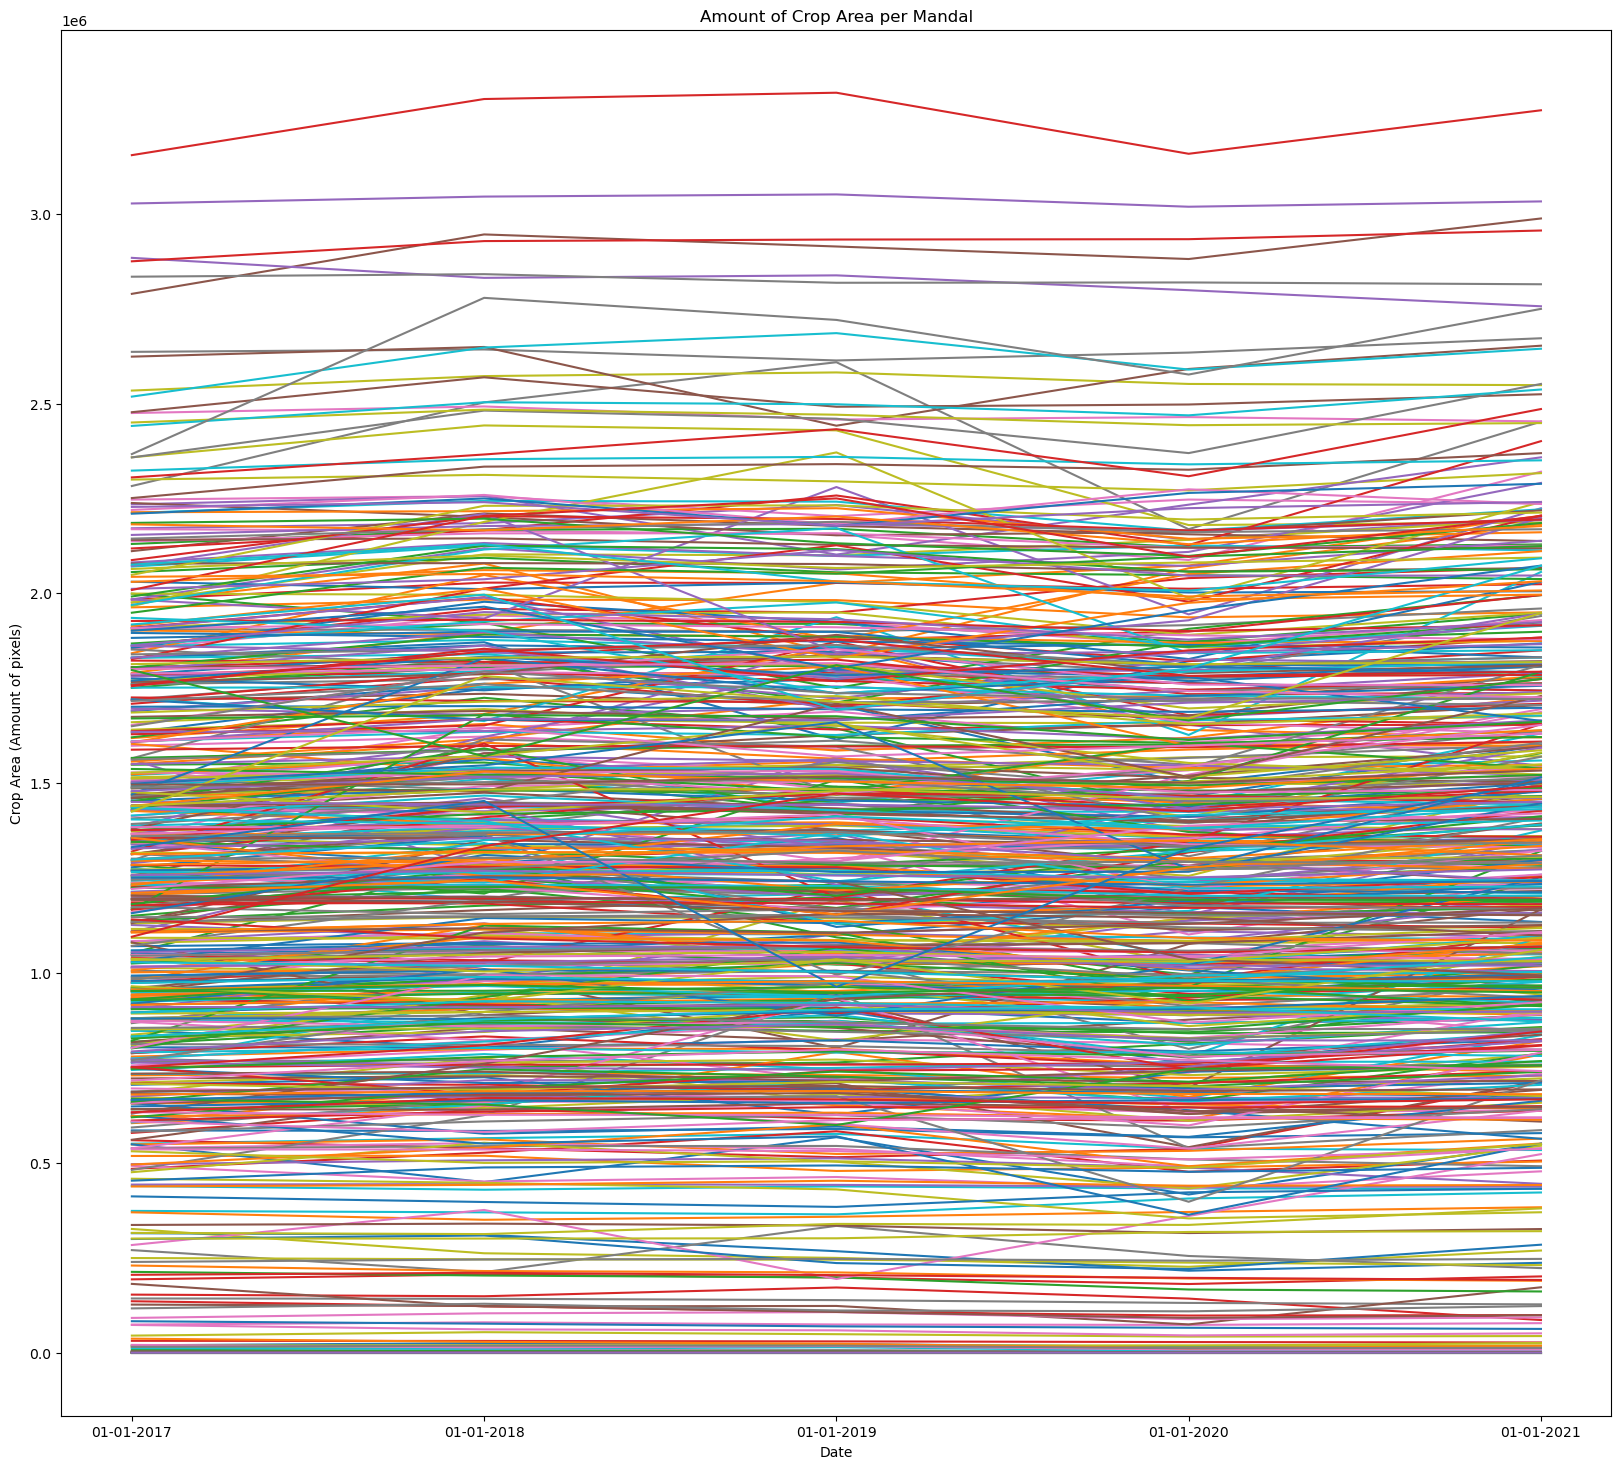

In [81]:
fig = plt.figure(figsize = (20,18))

for i in range(0, len(mandal_boundaries)):
    x_axis = ['01-01-2017', '01-01-2018', '01-01-2019', '01-01-2020', '01-01-2021']
    y_axis = crops_over_time[i].to_list()
    plt.plot(x_axis, y_axis)

plt.title('Amount of Crop Area per Mandal')
plt.xlabel('Date')
plt.ylabel('Crop Area (Amount of pixels)')
plt.show()

In [101]:
from statsmodels.tsa.stattools import adfuller     
from statsmodels.tsa.stattools import kpss

adf_test = []
kpss_test = []
for i in range(0, len(mandal_boundaries)):
    X = crops_over_time[i]
    result = adfuller(X)
    adf_test.append(result[1])

    try:
        kpsstest = kpss(X, regression='c', nlags="auto")
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
        kpss_test.append(kpss_output[1])
    except:
        kpss_test.append(0.1)


c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available i

<Figure size 2000x1800 with 0 Axes>

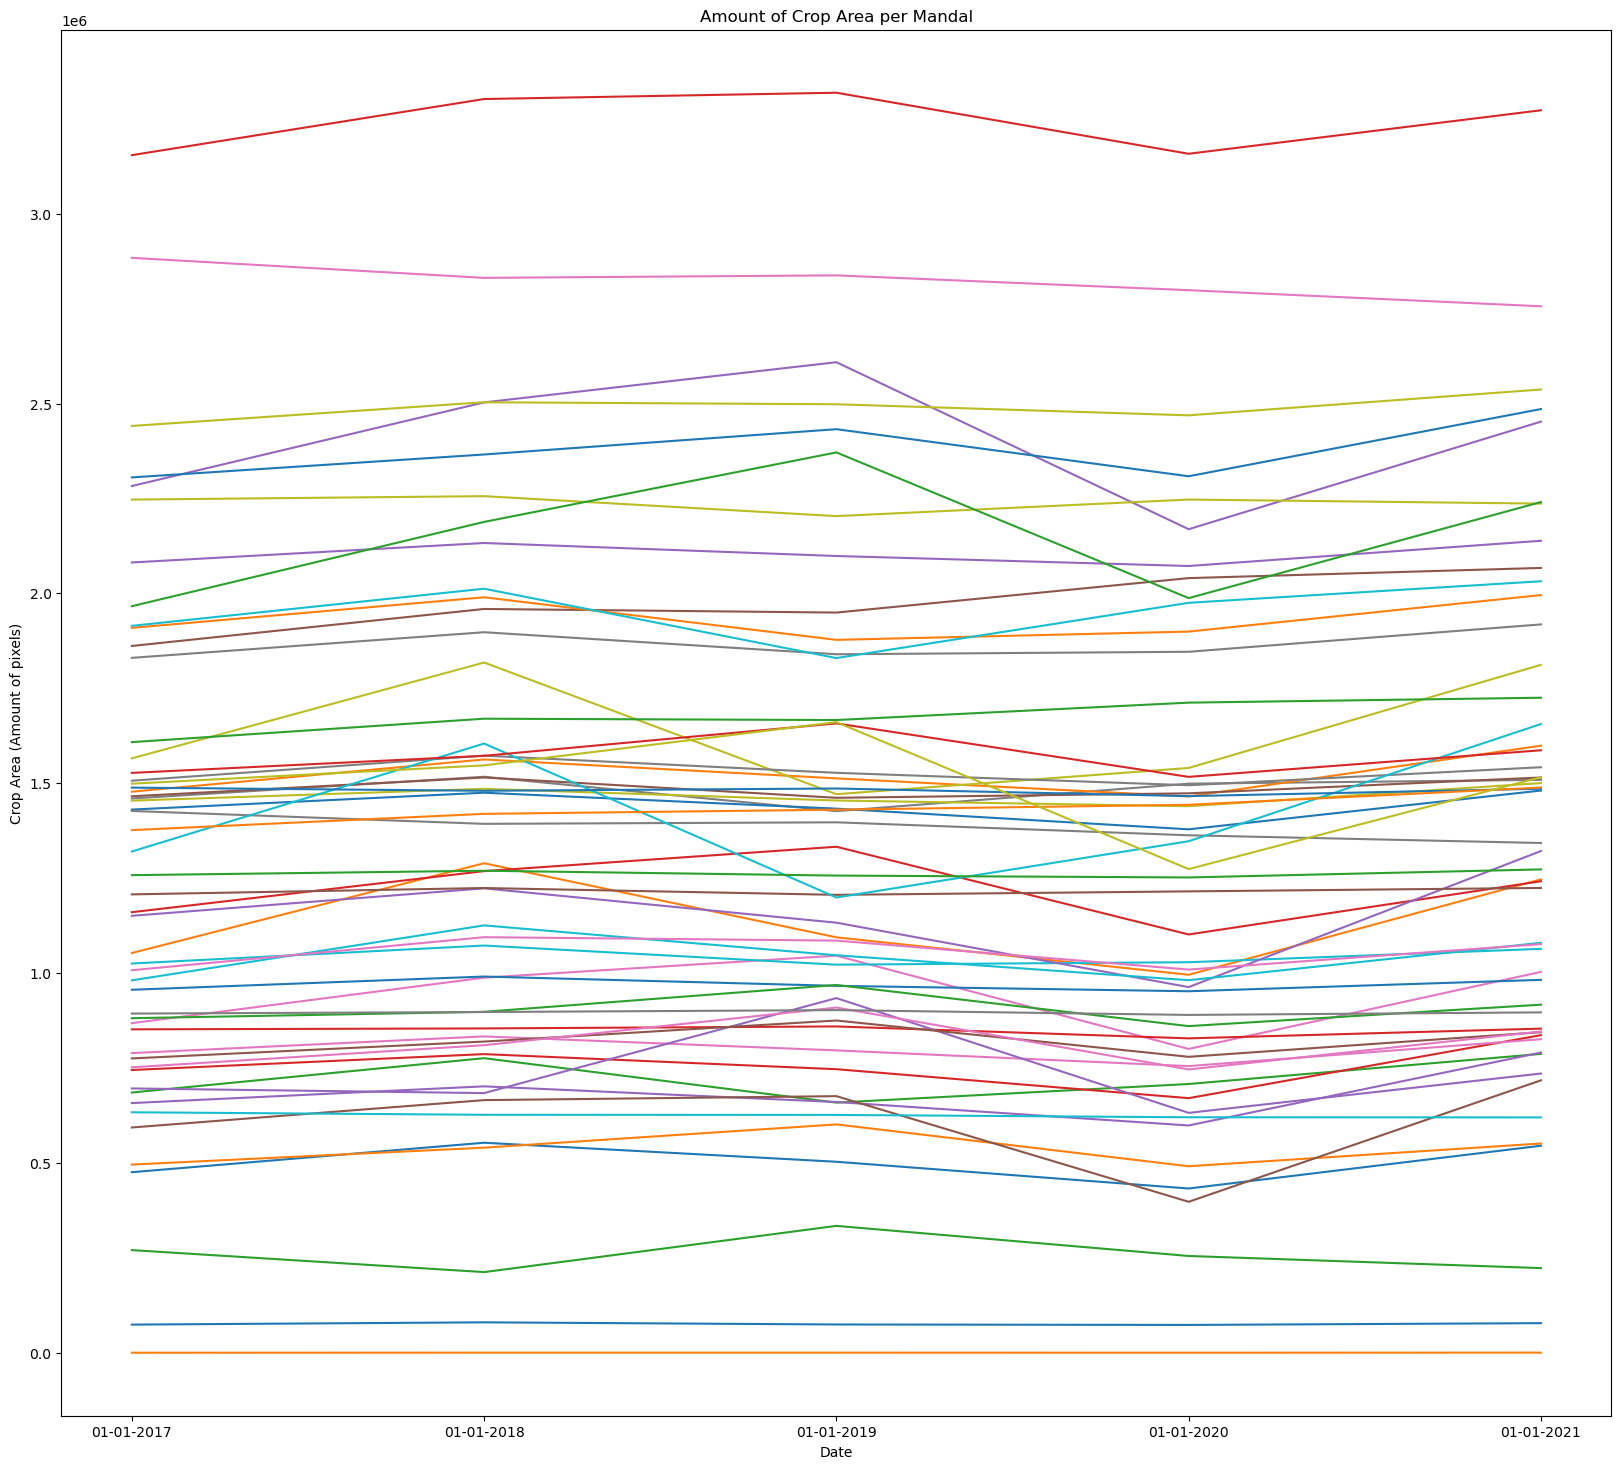

In [110]:
fig = plt.figure(figsize = (20,18))

for i in range(0, len(mandal_boundaries)):
    kpss_test[i]
    if (kpss_test[i]<0.05) & (adf_test[i]>0.05):
        x_axis = ['01-01-2017', '01-01-2018', '01-01-2019', '01-01-2020', '01-01-2021']
        y_axis = crops_over_time[i].to_list()
        plt.plot(x_axis, y_axis)

plt.title('Amount of Crop Area per Mandal')
plt.xlabel('Date')
plt.ylabel('Crop Area (Amount of pixels)')
plt.show()

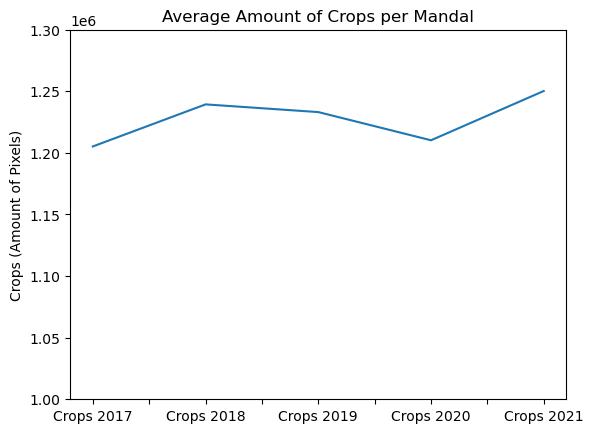

In [124]:
crops_over_time.mean(axis = 1).plot()
plt.ylim(1000000, 1300000)
plt.title('Average Amount of Crops per Mandal')
plt.ylabel('Crops (Amount of Pixels)')
plt.show()
